MYSQL EXPLORATORY DATA ANALYSIS USING PYTHON-PANDAS...
By AL

In [1]:
# import libraries
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Establish  and verfiy connection to mysql server
conn = mysql.connector.connect(
    host="localhost",
    user="",
    password="",
    database="InventoryDB"
)

# Establish cursor for query
cursor = conn.cursor()

# Check if connection is successful
if conn.is_connected():
    print("Connected to MySQL database")
else:
    print("Not connected")

# Close the connection
conn.close()

Connected to MySQL database


What tables are part of the database schema?

In [3]:
conn.connect()
try:
    # get tables of database   
    cursor.execute("SHOW TABLES")
    tables = cursor.fetchall()
    print(f"Tabels: {tables}")
    
finally:
    # Close connection
    conn.close()

Tabels: [('categories',), ('customers',), ('orderdetails',), ('orders',), ('products',), ('suppliers',)]


What datapoints are there for customers in the database?

In [4]:
# Open connection
conn.connect()
try:   
    cursor.execute("SELECT * FROM customers")

    # Get headers
    headers = [i[0] for i in cursor.description]
    print(headers)

    # get rows of data
    rows = cursor.fetchall()
    #for row in rows:
        #print(row)
finally:
    # Close connection
    conn.close()

['customer_id', 'name', 'email', 'phone', 'address', 'state', 'gender']


In [5]:
# creating a panda df with the sql query
dfcustomer = pd.DataFrame(data=rows,columns=headers).set_index(['customer_id'])
dfcustomer.head()

,name,email,phone,address,state,gender
customer_id,,,,,,
1,Alice Johnson,alice@example.com,111222333,789 Main St,PA,Female
2,Bob Williams,bob@example.com,444555666,321 Oak St,LA,Male
3,Charlie Green,charlie@example.com,777888999,654 Elm St,NV,Male
4,David Miller,david@example.com,333444555,987 Pine St,PA,Male
5,Emma Thomas,emma@example.com,666777888,123 Maple St,CO,Female


Customer demographics?

In [6]:
# general stats on the customer table
dfcustomer.describe()

,name,email,phone,address,state,gender
count,20,20,20,20,20,20
unique,20,20,19,20,10,2
top,Alice Johnson,alice@example.com,333222111,789 Main St,PA,Male
freq,1,1,2,1,5,12


<Axes: xlabel='gender'>

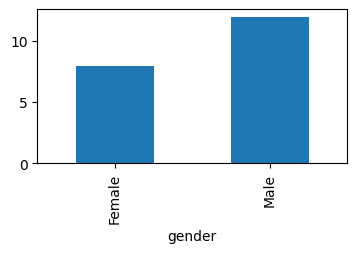

In [7]:
# breakdown of gender of the customers
dfcustomer[['gender','name']].groupby(by='gender').count().plot(kind='bar',figsize=(4,2),legend=False)

What customers are placing the most orders?

In [8]:
# get the order details 
conn.connect()
try:
    cursor.execute('SELECT * FROM orders')
    # get headers
    headers = [i[0] for i in cursor.description]
    
    # get rows
    rows = cursor.fetchall()

    # directly create pandas df
    dforderdetails = pd.DataFrame(data=rows,columns=headers).set_index('order_id') 

finally:
    conn.close() 

# verify sql query
dforderdetails.head()

,customer_id,order_date,total_amount,status
order_id,,,,
1,1,2024-05-01 10:30:00,1200.00,Completed
2,2,2024-05-02 12:45:00,150.00,Pending
3,3,2024-05-03 09:20:00,800.00,Shipped
4,1,2024-05-04 15:10:00,500.00,Processing
5,2,2024-05-05 11:00:00,45.00,Completed


In [32]:
# joining df querys to look at customer order history, left join to keep complete customer list
dfcustomerorders = pd.merge(dfcustomer,dforderdetails,on='customer_id',how='left').set_index('customer_id')
dfcustomerorders.head()

,name,email,phone,address,state,gender,order_date,total_amount,status
customer_id,,,,,,,,,
1,Alice Johnson,alice@example.com,111222333,789 Main St,PA,Female,2024-05-01 10:30:00,1200.00,Completed
1,Alice Johnson,alice@example.com,111222333,789 Main St,PA,Female,2024-05-04 15:10:00,500.00,Processing
1,Alice Johnson,alice@example.com,111222333,789 Main St,PA,Female,2025-05-01 10:30:00,1200.00,Completed
1,Alice Johnson,alice@example.com,111222333,789 Main St,PA,Female,2025-05-04 15:10:00,500.00,Processing
2,Bob Williams,bob@example.com,444555666,321 Oak St,LA,Male,2024-05-02 12:45:00,150.00,Pending


What is the total sum of orders placed? 

In [45]:
qry_aggsum = dfcustomerorders['total_amount'].fillna(0)
qry_aggsum.sum()

Decimal('13110.00')

In [10]:
# create query of order count by customer
qry_orders = (dfcustomerorders[['name','gender','address','phone','status','state']]
.groupby(by=['customer_id','name','gender','address','phone','state']).count()
.rename(columns={'status': 'order count'})
)

In [11]:
# check customers who placed the most orders
qry_orders.loc[qry_orders['order count'] > 0].sort_values(by='order count',ascending=False)

,,,,,,order count
customer_id,name,gender,address,phone,state,
3,Charlie Green,Male,654 Elm St,777888999,NV,8
2,Bob Williams,Male,321 Oak St,444555666,LA,6
5,Emma Thomas,Female,123 Maple St,666777888,CO,6
12,Mia Evans,Female,678 River Rd,555444333,TX,6
1,Alice Johnson,Female,789 Main St,111222333,PA,4
9,Isaac Walker,Male,678 Cherry St,000111222,LA,4
11,Liam Carter,Male,901 Lake St,444333222,RI,4
6,Frank Robinson,Male,876 Cedar St,222333444,NY,2


what is the sum total of orders placed by customers?

In [12]:
# create a query of total amount spent per customer
qry_totalsum = (dfcustomerorders[['name','gender','address','phone','state','total_amount']]
 .groupby(by=['customer_id','name','gender','address','phone','state'])
 .sum()
 )

In [13]:
# customer totals spent sorted
qry_totalsum.loc[qry_totalsum['total_amount']>0].sort_values(by='total_amount',ascending=False)

,,,,,,total_amount
customer_id,name,gender,address,phone,state,
1,Alice Johnson,Female,789 Main St,111222333,PA,3400.00
3,Charlie Green,Male,654 Elm St,777888999,NV,2950.00
5,Emma Thomas,Female,123 Maple St,666777888,CO,1770.00
9,Isaac Walker,Male,678 Cherry St,000111222,LA,1600.00
12,Mia Evans,Female,678 River Rd,555444333,TX,1500.00
11,Liam Carter,Male,901 Lake St,444333222,RI,1300.00
2,Bob Williams,Male,321 Oak St,444555666,LA,470.00
6,Frank Robinson,Male,876 Cedar St,222333444,NY,120.00


In [14]:
# combine the total orders placed per customer and the total spent per customer
dforderamount= pd.merge(left=qry_orders,right=qry_totalsum,how='inner',on=['customer_id','name','gender','address','phone','state'])
dforderamount.head()

,,,,,,order count,total_amount
customer_id,name,gender,address,phone,state,,
1,Alice Johnson,Female,789 Main St,111222333,PA,4,3400.00
2,Bob Williams,Male,321 Oak St,444555666,LA,6,470.00
3,Charlie Green,Male,654 Elm St,777888999,NV,8,2950.00
4,David Miller,Male,987 Pine St,333444555,PA,0,0
5,Emma Thomas,Female,123 Maple St,666777888,CO,6,1770.00


Is there any correlation between the qty of orders and total amount spent?

In [15]:
# view correlation
dforderamount[['order count','total_amount']].corr()

,order count,total_amount
order count,1.000000,0.812718
total_amount,0.812718,1.000000


<Axes: xlabel='order count', ylabel='total_amount'>

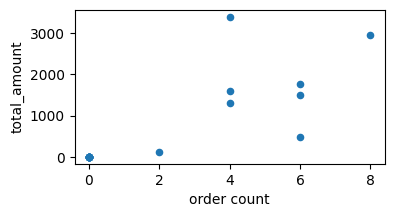

In [16]:
dforderamount[['order count','total_amount']].plot(kind='scatter',x=0,y=1,figsize=(4,2))

What is the gender breakdown of sales?

In [17]:
# change total column d type
dfcustomerorders['total_amount'] = pd.to_numeric(dfcustomerorders['total_amount'], errors='coerce')

In [18]:
# calcutes sales by gender
dfcustomerorders[['gender','total_amount']].groupby(by='gender').sum()

,total_amount
gender,
Female,6670.0
Male,6440.0


<Axes: ylabel='total_amount'>

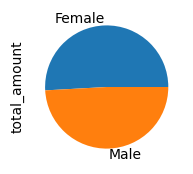

In [19]:
dfcustomerorders[['gender','total_amount']].groupby(by='gender').sum().plot(kind='pie',y=0,figsize=(2,2),legend=False)

In [20]:
# reset the index of df for better analysis
dforderamount.reset_index(inplace=True)
dforderamount.set_index('customer_id',inplace=True)

What is the sales breakdown by state?

In [21]:
# query the total amount sold by state.
qry_salesbystate = dforderamount[['state','order count','total_amount']].groupby(by='state').sum()
qry_salesbystate

,order count,total_amount
state,,
CO,6,1770.00
FL,0,0
LA,10,2070.00
NC,0,0
NV,8,2950.00
NY,2,120.00
PA,4,3400.00
RI,4,1300.00
TX,6,1500.00


In [22]:
# change data type of total amount column
qry_salesbystate['total_amount'] = pd.to_numeric(qry_salesbystate['total_amount'], errors='coerce')

<Axes: ylabel='state'>

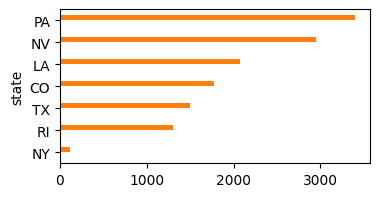

In [23]:
(qry_salesbystate
 .loc[qry_salesbystate['total_amount']>0]
 .sort_values(by='total_amount')
 .plot(kind='barh',figsize=(4,2),legend=False))

What state is placing the most orders?

<Axes: ylabel='state'>

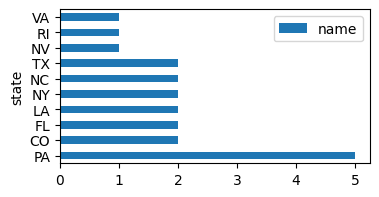

In [24]:
# states with the most customers
dfcustomer[['state','name']].groupby(by='state').count().sort_values(by='name',ascending=False).plot(kind='barh',figsize=(4,2))